In [13]:
import numpy as np
import pandas as pd
import random

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from deap import base, creator, tools, algorithms

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report
)

from xgboost import XGBClassifier
from scipy.special import softmax


In [2]:
df = pd.read_csv("X+aki_stage-corr.csv")

target_column = "aki_stage"  # Target variable
df["aki_stage"] = df["aki_stage"].astype("category")
print(df["aki_stage"].dtype)  # Should display "category"
print(df["aki_stage"].unique())  # Display unique categories

def setup_features_and_target(df, target):
    y = df[target]
    X = df.drop(columns=[target], errors='ignore')  # Remove ID column if it exists
    return X, y

X, y = setup_features_and_target(df, target_column)

category
[0, 2, 1, 3]
Categories (4, int64): [0, 1, 2, 3]


In [ ]:
# Set random seed
random.seed(30)

#Fitness Function
def evaluate(individual):
    """Calculate the fitness of an individual (feature subset) using Logistic Regression + 5-fold cross-validation."""
    selected_features = [index for index, bit in enumerate(individual) if bit == 1]
    
    # If no features are selected, return a poor fitness score
    if len(selected_features) == 0:
        return 0,
    
    # Select the feature subset
    X_selected = X.iloc[:, selected_features]

    # Compute cross-validation accuracy
    clf = LogisticRegression(solver='liblinear', random_state=30)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
    scores = cross_val_score(clf, X_selected, y, cv=cv, scoring='accuracy')
    
    return scores.mean(),  # Return the fitness score

#Genetic Algorithm Parameters
num_features = X.shape[1]  # Number of features
population_size = 30  # Population size
num_generations = 20  # Number of generations
mutation_prob = 0.2  # Mutation probability
crossover_prob = 0.5  # Crossover probability

#Define Genetic Algorithm Components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizing fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)  # Generate 0/1 for feature selection
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)  # Crossover (two-point crossover)
toolbox.register("mutate", tools.mutFlipBit, indpb=mutation_prob)  # Mutation (random bit flip)
toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection
toolbox.register("evaluate", evaluate)  # Fitness evaluation

#Run Genetic Algorithm
pop = toolbox.population(n=population_size)
algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=num_generations, verbose=True)

#Select the Best Individual
best_individual = tools.selBest(pop, k=1)[0]
selected_features_idx = [index for index, bit in enumerate(best_individual) if bit == 1]
selected_features = X.columns[selected_features_idx]

print(f"\n Number of features selected by Genetic Algorithm: {len(selected_features)}")
print("Selected features:", selected_features.tolist())

#Generate the Final Feature Subset
X_selected_ga = X[selected_features]

gen	nevals
0  	30    
1  	20    
2  	19    
3  	14    
4  	13    
5  	21    
6  	19    
7  	24    
8  	13    
9  	18    
10 	16    
11 	19    
12 	21    
13 	15    
14 	15    
15 	20    
16 	18    
17 	23    
18 	15    
19 	21    
20 	20    

 Number of features selected by Genetic Algorithm: 53
Selected features: ['gender', 'admission_age', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_max', 'mbp_max', 'resp_rate_max', 'resp_rate_mean', 'temperature_vital_min', 'temperature_vital_max', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_vital_max', 'lactate_min', 'ph_min', 'ph_max', 'po2_max', 'pco2_max', 'baseexcess_min', 'hematocrit_lab_min', 'platelets_min', 'aniongap_min', 'aniongap_max', 'bicarbonate_lab_max', 'bun_min', 'calcium_lab_min', 'calcium_lab_max', 'chloride_lab_min', 'chloride_lab_max', 'creatinine_min', 'glucose_lab_min', 'sodium_lab_min', 'sodium_lab_max', 'potassium_lab_min', 'potassium_lab_max', 'abs_basophils_min', 'abs_eosinophils_min', 'abs_lymphocytes_min', 'abs_monocytes_m

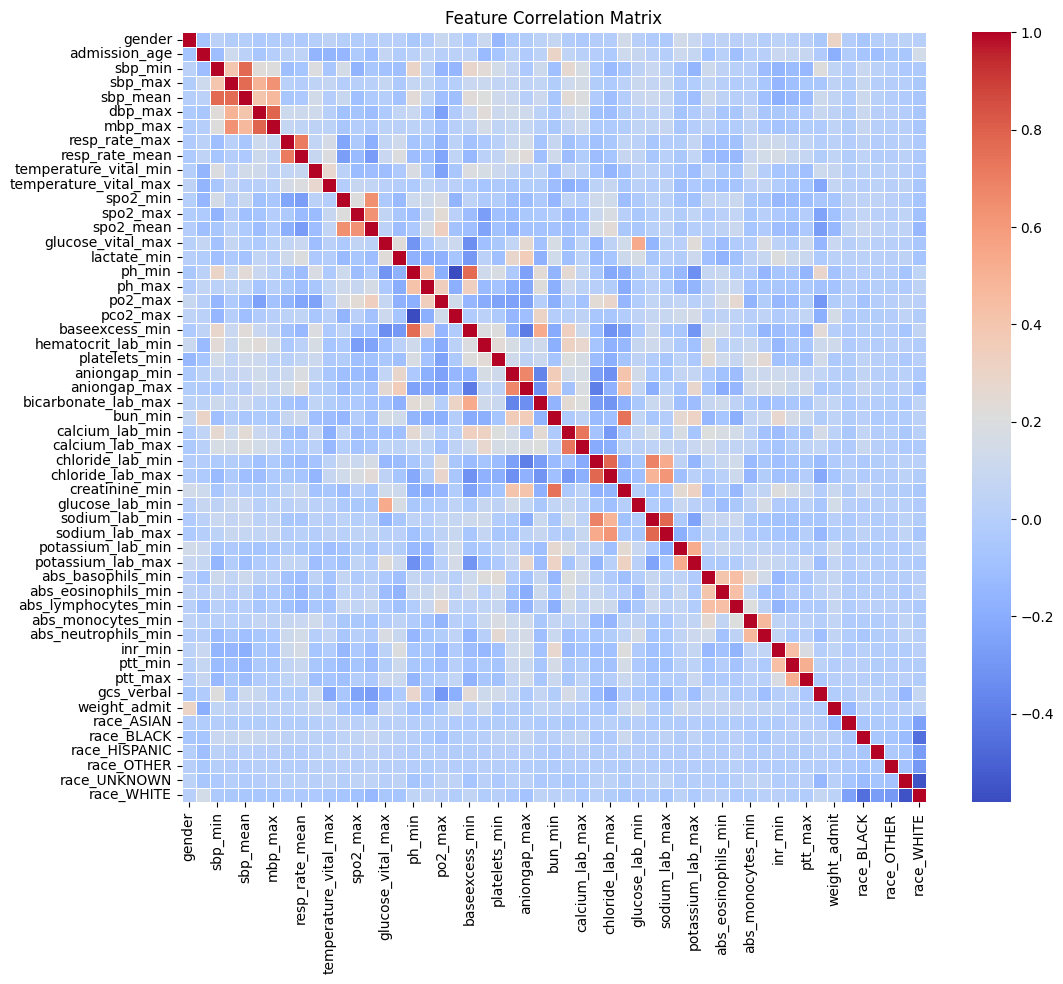

Feature Correlation Matrix (Pearson):

                       gender  admission_age  sbp_min  sbp_max  sbp_mean  \
gender                  1.000         -0.070    0.028   -0.008     0.003   
admission_age          -0.070          1.000   -0.106    0.122     0.030   
sbp_min                 0.028         -0.106    1.000    0.399     0.771   
sbp_max                -0.008          0.122    0.399    1.000     0.770   
sbp_mean                0.003          0.030    0.771    0.770     1.000   
dbp_max                -0.028         -0.056    0.227    0.496     0.406   
mbp_max                -0.016         -0.000    0.214    0.632     0.464   
resp_rate_max          -0.023          0.027   -0.106    0.017    -0.060   
resp_rate_mean         -0.029          0.045   -0.063   -0.003    -0.039   
temperature_vital_min  -0.001         -0.162    0.196    0.042     0.138   
temperature_vital_max   0.036         -0.157   -0.055    0.070    -0.006   
spo2_min                0.004         -0.148    0

In [4]:
# Compute the correlation matrix (default: Pearson correlation coefficient)
correlation_matrix = X_selected_ga.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Print the correlation matrix
print("Feature Correlation Matrix (Pearson):\n")
print(correlation_matrix.round(3))

In [63]:
final_features = [
    # **Basic Information**
    "gender", "admission_age", "weight_admit",
    
    # **Blood Pressure**
    "sbp_mean",   # Mean SBP (Removed sbp_min and sbp_max)
    "dbp_max",    # Maximum DBP (Captures peak blood pressure)
    "mbp_max",    # Maximum MBP (Complements DBP)
    
    # **Respiration & Oxygen Saturation**
    "resp_rate_mean",   # Mean respiratory rate (Avoids fluctuations)
    "spo2_mean",        # Mean SpO2 (Removed spo2_min and spo2_max)
    
    # **Temperature**
    "temperature_vital_max",  # Maximum temperature (Fever-related risks)
    
    # **Blood Sugar & Lactate**
    "glucose_vital_max",  # Maximum blood glucose (Metabolic disorder indicator)
    "lactate_min",  # Minimum lactate (Key marker for shock and critical illness)
    
    # **Acid-Base Balance & Gases**
    "ph_min",  # Minimum pH (Risk of acidosis)
    "po2_max",  # Maximum PO2 (Oxygen uptake capacity)
    "pco2_max",  # Maximum PCO2 (CO2 retention risk)
    
    # **Electrolytes & Metabolism**
    "aniongap_max",  # Maximum anion gap (Metabolic acidosis marker)
    "bicarbonate_lab_max",  # Maximum bicarbonate (Acid-base balance indicator)
    "sodium_lab_max",  # Maximum sodium (Removed sodium_lab_min)
    "potassium_lab_max",  # Maximum potassium (Removed potassium_lab_min)
    
    # **Renal Function**
    "bun_min",  # Minimum blood urea nitrogen (Acute kidney injury risk)
    "creatinine_min",  # Minimum creatinine (Kidney function indicator)
    
    # **Blood Cells**
    "hematocrit_lab_min",  # Minimum hematocrit (Anemia risk)
    "platelets_min",  # Minimum platelets (Coagulation function)
    
    # **Coagulation Function**
    "ptt_max",  # Maximum PTT (Removed ptt_min, retained the max value)
    
    # **Consciousness Level**
    "gcs_verbal",  # GCS verbal score (Neurological status)
    
]

# Correctly reference the defined variable name
X_final_selected = X_selected_ga[final_features]

# Print the number of final selected features
print(f"\n Number of Final Refined Features: {len(final_features)}")
print(" Final Retained Features:", final_features)


 Number of Final Refined Features: 24
 Final Retained Features: ['gender', 'admission_age', 'weight_admit', 'sbp_mean', 'dbp_max', 'mbp_max', 'resp_rate_mean', 'spo2_mean', 'temperature_vital_max', 'glucose_vital_max', 'lactate_min', 'ph_min', 'po2_max', 'pco2_max', 'aniongap_max', 'bicarbonate_lab_max', 'sodium_lab_max', 'potassium_lab_max', 'bun_min', 'creatinine_min', 'hematocrit_lab_min', 'platelets_min', 'ptt_max', 'gcs_verbal']


In [66]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(" Class distribution in y_train:", np.bincount(y_train))
print(" Class distribution in y_test:", np.bincount(y_test))

 Class distribution in y_train: [12994  7670 12690  6110]
 Class distribution in y_test: [3249 1918 3173 1527]


In [67]:
# Initialize SGDClassifier (Logistic Regression with Gradient Descent Optimization)
sgd_clf = SGDClassifier(
    loss='log_loss',        # Logistic regression
    penalty='elasticnet',   # Mixed regularization
    l1_ratio=0.3,
    learning_rate='constant',
    eta0=0.01,
    max_iter=5000,
    random_state=42,
    class_weight='balanced',
    tol=1e-4
)

# Train the classifier using GA-refined features
sgd_clf.fit(X_train, y_train)

# Compute decision scores
y_decision = sgd_clf.decision_function(X_test)

# Apply softmax to obtain class probabilities
y_prob = softmax(y_decision, axis=1)

# Make predictions
y_pred = sgd_clf.predict(X_test)

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute multi-class ROC-AUC (One-vs-One)
roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovo')

# Model Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion Matrix
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print("Multinomial Logistic Regression Evaluation Results (Refined GA Features):")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision:.4f}")
print(f" Recall (Macro): {recall:.4f}")
print(f" F1 Score (Macro): {f1:.4f}")
print(f" ROC AUC (OvO): {roc_auc:.4f}")
print("\n Confusion Matrix:\n", conf_matrix)

Multinomial Logistic Regression Evaluation Results (Refined GA Features):
 Accuracy: 0.4579
 Precision (Macro): 0.4062
 Recall (Macro): 0.4250
 F1 Score (Macro): 0.3960
 ROC AUC (OvO): 0.6848

 Confusion Matrix:
 Predicted     0    1     2    3
Actual                         
0          2189  145   633  282
1           829  128   621  340
2          1003  161  1419  590
3           239   48   458  782


In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)
from sklearn.preprocessing import label_binarize

# Explicitly specify multi:softprob for multi-class classification
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    n_estimators=250,
    learning_rate=0.08,
    max_depth=4,
    random_state=30,
    tree_method="hist",
    subsample=0.8,  # Use 80% of data for each boosting round
    colsample_bytree=0.8  # Use 80% of features per tree
    
)
# Train the XGBoost model on the GA-selected features
xgb_clf.fit(X_train, y_train)

# Predict probabilities
y_prob_xgb = xgb_clf.predict_proba(X_test)

# Predict class labels
y_pred_xgb = xgb_clf.predict(X_test)  # Ensure predictions are defined

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute multi-class ROC-AUC (One-vs-One)
roc_auc_xgb = roc_auc_score(y_test_bin, y_prob_xgb, multi_class='ovo')

# Model Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

# Confusion Matrix
conf_matrix = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print("XGBoost Model Evaluation Results (Refined GA Features):")
print(f" XGBoost ROC AUC: {roc_auc_xgb:.4f}")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision_macro:.4f}")
print(f" Recall (Macro): {recall_macro:.4f}")
print(f" F1 Score (Macro): {f1_macro:.4f}")
print("\n Confusion Matrix:\n", conf_matrix)


XGBoost Model Evaluation Results (Refined GA Features):
 XGBoost ROC AUC: 0.7176
 Accuracy: 0.4962
 Precision (Macro): 0.4705
 Recall (Macro): 0.4352
 F1 Score (Macro): 0.4127

 Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2238  59   842  110
1           828  75   864  151
2           891  56  1998  228
3           213  26   703  585


In [69]:
from sklearn.preprocessing import OrdinalEncoder

# Convert target to ordinal values (0,1,2,...)
ordinal_encoder = OrdinalEncoder()

# Fix: Use .values or .to_numpy() before reshaping
y_train_ord = ordinal_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_ord = ordinal_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

print("Encoded y_train:", y_train_ord[:5])
print("Encoded y_test:", y_test_ord[:5])

# Initialize XGBoost with custom loss function
xgb_ordinal = xgb.XGBClassifier(
    objective="reg:squarederror",  # Using regression loss to capture ordinal structure
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train the model
xgb_ordinal.fit(X_train, y_train_ord)

# Predict class labels
y_pred_xgb_ord = xgb_ordinal.predict(X_test)

# Compute Evaluation Metrics
accuracy_xgb_ord = accuracy_score(y_test_ord, y_pred_xgb_ord)
f1_xgb_ord = f1_score(y_test_ord, y_pred_xgb_ord, average='macro')

# Print Results
print("Ordinal XGBoost Evaluation:")
print(f" Accuracy: {accuracy_xgb_ord:.4f}")
print(f" F1 Score (Macro): {f1_xgb_ord:.4f}")

Encoded y_train: [3. 1. 1. 2. 0.]
Encoded y_test: [3. 0. 2. 0. 2.]
Ordinal XGBoost Evaluation:
 Accuracy: 0.4903
 F1 Score (Macro): 0.4041


In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)
from sklearn.preprocessing import label_binarize

# Initialize Decision Tree Classifier
dt_clf = DecisionTreeClassifier(
    criterion='entropy',  # Use entropy for information gain (alternative: 'gini')
    max_depth=8,  # Control tree depth to prevent overfitting
    random_state=42
)

# Train Decision Tree on GA-selected features
dt_clf.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_clf.predict(X_test)
y_prob_dt = dt_clf.predict_proba(X_test)  # Predict probabilities

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute Evaluation Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='macro')
recall_dt = recall_score(y_test, y_pred_dt, average='macro')
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
roc_auc_dt = roc_auc_score(y_test_bin, y_prob_dt, multi_class='ovo')

# Print Results
print("Decision Tree Model Evaluation (Refined GA Features):")
print(f" Decision Tree ROC AUC: {roc_auc_dt:.4f}")
print(f" Accuracy: {accuracy_dt:.4f}")
print(f" Precision (Macro): {precision_dt:.4f}")
print(f" Recall (Macro): {recall_dt:.4f}")
print(f" F1 Score (Macro): {f1_dt:.4f}")

# Confusion Matrix
conf_matrix_dt = pd.crosstab(y_test, y_pred_dt, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", conf_matrix_dt)

Decision Tree Model Evaluation (Refined GA Features):
 Decision Tree ROC AUC: 0.6651
 Accuracy: 0.4422
 Precision (Macro): 0.4051
 Recall (Macro): 0.3838
 F1 Score (Macro): 0.3630

Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2199  60   876  114
1           962  69   728  159
2          1225  86  1618  244
3           291  52   707  477


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)
from sklearn.preprocessing import label_binarize

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=5,  # Control tree depth to prevent overfitting
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)

# Train Random Forest on GA-selected features
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)  # Predict probabilities

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
roc_auc_rf = roc_auc_score(y_test_bin, y_prob_rf, multi_class='ovo')

# Print Results
print("Random Forest Model Evaluation (Refined GA Features):")
print(f" Random Forest ROC AUC: {roc_auc_rf:.4f}")
print(f" Accuracy: {accuracy_rf:.4f}")
print(f" Precision (Macro): {precision_rf:.4f}")
print(f" Recall (Macro): {recall_rf:.4f}")
print(f" F1 Score (Macro): {f1_rf:.4f}")

# Confusion Matrix
conf_matrix_rf = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", conf_matrix_rf)

Random Forest Model Evaluation (Refined GA Features):
 Random Forest ROC AUC: 0.6853
 Accuracy: 0.4469
 Precision (Macro): 0.4013
 Recall (Macro): 0.4272
 F1 Score (Macro): 0.3958

Confusion Matrix:
 Predicted     0    1     2    3
Actual                         
0          2113  210   588  338
1           804  172   537  405
2           992  239  1245  697
3           228   31   388  880


In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)
from sklearn.preprocessing import label_binarize

# Initialize AdaBoost Classifier (Base Estimator: Shallow Decision Tree)
ab_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Use shallow Decision Tree as weak learner
    n_estimators=200,  # Number of boosting iterations
    learning_rate=0.05,  # Learning rate control
    random_state=30
)

# Train AdaBoost on GA-selected features
ab_clf.fit(X_train, y_train)

# Predictions
y_pred_ab = ab_clf.predict(X_test)
y_prob_ab = ab_clf.predict_proba(X_test)  # Predict probabilities

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute Evaluation Metrics
accuracy_ab = accuracy_score(y_test, y_pred_ab)
precision_ab = precision_score(y_test, y_pred_ab, average='macro')
recall_ab = recall_score(y_test, y_pred_ab, average='macro')
f1_ab = f1_score(y_test, y_pred_ab, average='macro')
roc_auc_ab = roc_auc_score(y_test_bin, y_prob_ab, multi_class='ovo')

# Print Results
print("AdaBoost Model Evaluation (Refined GA Features):")
print(f" AdaBoost ROC AUC: {roc_auc_ab:.4f}")
print(f" Accuracy: {accuracy_ab:.4f}")
print(f" Precision (Macro): {precision_ab:.4f}")
print(f" Recall (Macro): {recall_ab:.4f}")
print(f" F1 Score (Macro): {f1_ab:.4f}")

# Confusion Matrix
conf_matrix_ab = pd.crosstab(y_test, y_pred_ab, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", conf_matrix_ab)

AdaBoost Model Evaluation (Refined GA Features):
 AdaBoost ROC AUC: 0.6877
 Accuracy: 0.4636
 Precision (Macro): 0.4474
 Recall (Macro): 0.4013
 F1 Score (Macro): 0.3702

Confusion Matrix:
 Predicted     0  1     2    3
Actual                       
0          2117  4  1020  108
1           841  6   907  164
2          1022  5  1927  219
3           205  2   796  524


In [73]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)

# SVM requires feature standardization
svm_clf = make_pipeline(
    StandardScaler(),  # Normalize data
    SVC(
        kernel='rbf',  # Use RBF kernel
        probability=True,  # Enable probability estimates
        random_state=42
    )
)

# Train SVM on GA-selected features
svm_clf.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_clf.predict(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)  # Predict probabilities

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute Evaluation Metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
roc_auc_svm = roc_auc_score(y_test_bin, y_prob_svm, multi_class='ovo')

# Print Results
print("SVM Model Evaluation (Refined GA Features):")
print(f" SVM ROC AUC: {roc_auc_svm:.4f}")
print(f" Accuracy: {accuracy_svm:.4f}")
print(f" Precision (Macro): {precision_svm:.4f}")
print(f" Recall (Macro): {recall_svm:.4f}")
print(f" F1 Score (Macro): {f1_svm:.4f}")

# Confusion Matrix
conf_matrix_svm = pd.crosstab(y_test, y_pred_svm, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", conf_matrix_svm)

SVM Model Evaluation (Refined GA Features):
 SVM ROC AUC: 0.7049
 Accuracy: 0.4895
 Precision (Macro): 0.4606
 Recall (Macro): 0.4217
 F1 Score (Macro): 0.3937

Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2321  28   807   93
1           887  36   858  137
2           988  31  1960  194
3           236  16   762  513
